In [1]:
import os
import pyspark.mllib
import numpy as np
import matplotlib.pyplot
import seaborn as sns
import pyspark
import urllib
import pandas as pd
import datetime

from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext, SparkSession, Row
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import functions as func
from pyspark.mllib.regression import LinearRegressionWithSGD
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import DecisionTree
from IPython.display import display, HTML
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, VectorIndexer
import numpy as np
from numpy import array
%matplotlib inline
# get_ipython().magic(u'pylab inline')

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
modelDir = "models/"

In [3]:
### Initialize streaming context
conf = SparkConf()\
                .setMaster("local[2]")\
                .setAppName("MobileAnalyticsFeaturesExtraction")\
                .set("spark.executor.memory", "6g")\
                .set("spark.driver.memory", "6g")
sc = SparkContext(conf=conf)
sc.setLogLevel("ERROR")
sqlContext = SQLContext(sc)
spark = SparkSession.builder.appName("spark play").getOrCreate()

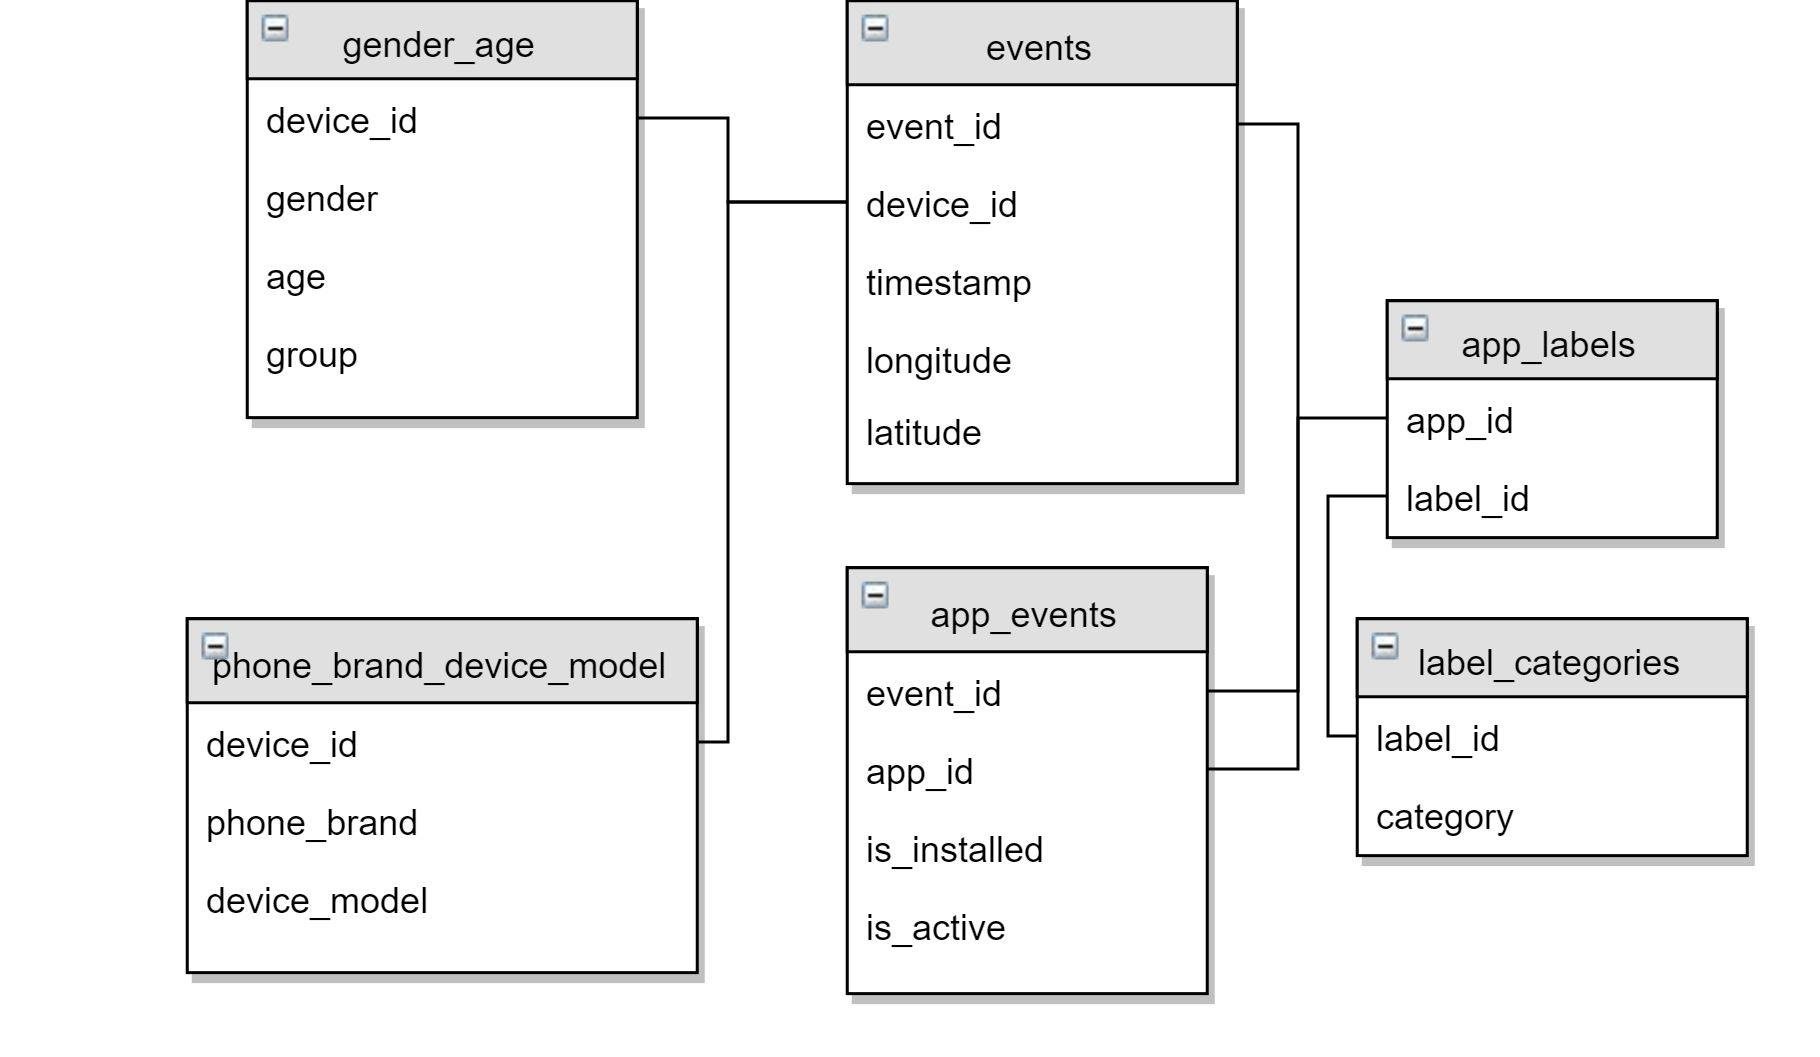

In [4]:
from IPython.display import Image
Image(filename='RelationalDatabasesFlow.jpg')

In [5]:
phone_brand_model_csv = "data/phone_brand_device_model_key.csv"
gender_age_train_csv = "data/gender_age_train.csv"
gender_age_test_csv = "data/gender_age_test.csv"
events_csv = "data/events.csv"
app_events_csv = "data/app_events.csv"
app_labels_csv ="data/app_labels.csv"
label_categories_csv = "data/label_categories.csv"

train_CSV ="data/train"
test_CSV ="data/test"

In [6]:
phone_brand_model = spark.read.csv("data/phone_brand_device_model.csv", header=True, mode="DROPMALFORMED", inferSchema='true').persist()
phone_brand_model = phone_brand_model.dropDuplicates() # Drop the 523 rows that were duplicated in this df 
print phone_brand_model.count() 
phone_brand_model.show() 

186722
+--------------------+-----------+---------------+
|           device_id|phone_brand|   device_model|
+--------------------+-----------+---------------+
|-5117743377362882952|       vivo|           Y20T|
| 5110524159866301228|         三星|      Galaxy S4|
|-7072818825604244920|         华为|      Ascend P7|
|-5676755765420948706|         小米|           MI 3|
|-6149728339109419295|         酷派|           8729|
|-5552529526587290631|         索尼| Xperia Z Ultra|
|-8585336662178724972|         三星|  Galaxy Note 2|
|-4126906565268243318|         小米|         红米note|
| 8968726039743714815|         小米|         红米note|
|-3211641070595508407|         华为|           荣耀3X|
| 4975882107557524914|         三星|     Galaxy Win|
| 3213948454433809554|       OPPO|         Find 5|
| 7459336563765701134|         酷派|          8190Q|
| 3623409337376721906|         华为|        荣耀3X畅玩版|
| 2135986898260804669|         魅族|            MX3|
|-2935449290329036734|         小米|          MI 1S|
| 1840712263548769769|  

In [7]:
gender_age_train = spark.read.csv(gender_age_train_csv, header=True, mode="DROPMALFORMED", inferSchema='true', encoding="utf-8").persist()
print gender_age_train.count() 
gender_age_train.show() 

74645
+--------------------+------+---+------+
|           device_id|gender|age| group|
+--------------------+------+---+------+
|-8076087639492063270|     M| 35|M32-38|
|-2897161552818060146|     M| 35|M32-38|
|-8260683887967679142|     M| 35|M32-38|
|-4938849341048082022|     M| 30|M29-31|
|  245133531816851882|     M| 30|M29-31|
|-1297074871525174196|     F| 24|F24-26|
|  236877999787307864|     M| 36|M32-38|
|-8098239495777311881|     M| 38|M32-38|
|  176515041953473526|     M| 33|M32-38|
| 1596610250680140042|     F| 36|F33-42|
| 9032155484127182494|     M| 31|M29-31|
| 7477216237379271436|     F| 37|F33-42|
| 2478205222798310601|     F| 28|F27-28|
| 6352067998666467520|     M| 32|M32-38|
|-7605360767281960867|     M| 48|  M39+|
| 1508636020748379883|     F| 28|F27-28|
| 4380872794486415327|     M| 38|M32-38|
|-1039701474753771322|     M| 38|M32-38|
|-6876541075223249434|     M| 75|  M39+|
| 6287938418661076759|     M| 33|M32-38|
+--------------------+------+---+------+
only showi

In [8]:
gender_age_test = spark.read.csv(gender_age_test_csv, header=True, mode="DROPMALFORMED", inferSchema='true', encoding="utf-8").persist()
print gender_age_test.count() 
gender_age_test.show()    

112071
+--------------------+
|           device_id|
+--------------------+
| 1002079943728939269|
|-1547860181818787117|
| 7374582448058474277|
|-6220210354783429585|
|-5893464122623104785|
|-7560708697029818408|
|  289797889702373958|
| -402874006399730161|
| 5751283639860028129|
| -848943298935149395|
| 6873889408535437611|
| 9097600484609173263|
| 7918118984690678938|
|-5723359257508971431|
|-5045999078783569038|
|-4466603005916311099|
| 6130118150534832946|
| 2245330978838477229|
| 6261900729835972204|
|  501940708836600976|
+--------------------+
only showing top 20 rows



In [9]:
events = spark.read.csv(events_csv, header=True, mode="DROPMALFORMED", inferSchema='true', encoding="utf-8").persist()
print events.count()
events.show()

3252950
+--------+--------------------+-------------------+---------+--------+
|event_id|           device_id|          timestamp|longitude|latitude|
+--------+--------------------+-------------------+---------+--------+
|       1|   29182687948017175|2016-05-01 00:55:25|   121.38|   31.24|
|       2|-6401643145415154744|2016-05-01 00:54:12|   103.65|   30.97|
|       3|-4833982096941402721|2016-05-01 00:08:05|    106.6|    29.7|
|       4|-6815121365017318426|2016-05-01 00:06:40|   104.27|   23.28|
|       5|-5373797595892518570|2016-05-01 00:07:18|   115.88|   28.66|
|       6| 1476664663289716375|2016-05-01 00:27:21|      0.0|     0.0|
|       7| 5990807147117726237|2016-05-01 00:15:13|   113.73|    23.0|
|       8| 1782450055857303792|2016-05-01 00:15:35|   113.94|    34.7|
|       9|-2073340001552902943|2016-05-01 00:15:33|      0.0|     0.0|
|      10|-8195816569128397698|2016-05-01 00:41:31|   119.34|   26.04|
|      11| 8663743929678393765|2016-05-01 00:44:13|   106.71|   39.51

In [10]:
app_events = spark.read.csv(app_events_csv, header=True, mode="DROPMALFORMED", inferSchema='true', encoding="utf-8").persist()
print app_events.count()
app_events.show()

32473067
+--------+--------------------+------------+---------+
|event_id|              app_id|is_installed|is_active|
+--------+--------------------+------------+---------+
|       2| 5927333115845830913|           1|        1|
|       2|-5720078949152207372|           1|        0|
|       2|-1633887856876571208|           1|        0|
|       2| -653184325010919369|           1|        1|
|       2| 8693964245073640147|           1|        1|
|       2| 4775896950989639373|           1|        1|
|       2|-8022267440849930066|           1|        0|
|       2| 9112463267739110219|           1|        0|
|       2|-3725672010020973973|           1|        0|
|       2| 7167114343576723123|           1|        1|
|       2|  487766649788038994|           1|        0|
|       2| 7460082553072507347|           1|        0|
|       2|  628020936226491308|           1|        0|
|       2|  701031210314548601|           1|        0|
|       2|-1758857579862594461|           1|        0|
|

In [11]:
app_labels = spark.read.csv(app_labels_csv, header=True, mode="DROPMALFORMED", inferSchema='true', encoding="utf-8").persist()
print app_labels.count()
app_labels.show()

459943
+--------------------+--------+
|              app_id|label_id|
+--------------------+--------+
| 7324884708820027918|     251|
|-4494216993218550286|     251|
| 6058196446775239644|     406|
| 6058196446775239644|     407|
| 8694625920731541625|     406|
| 8694625920731541625|     407|
| 1977658975649789753|     406|
| 1977658975649789753|     407|
| 7311663864768030840|     256|
| 5902120154267999338|     256|
| 2441810024319437760|     256|
| 8378607170315253667|     261|
|-7468212093586159919|     256|
|-6493194103110420302|     253|
| 3089609407449461199|     256|
| 2705437723590691734|     253|
|-1919793861139224050|     256|
| 4955831798976247953|     256|
|-7306728226531308671|     256|
| 1078279648391910971|     256|
+--------------------+--------+
only showing top 20 rows



In [12]:
label_categories = spark.read.csv(label_categories_csv, header=True, mode="DROPMALFORMED", inferSchema='true', encoding="utf-8").persist()
print label_categories.count()
label_categories.show()

930
+--------+--------------------+---------------+
|label_id|            category|label_itunes_id|
+--------+--------------------+---------------+
|       1|                null|             26|
|       2|      game-game type|              8|
|       3|    game-Game themes|              8|
|       4|      game-Art Style|              8|
|       5|   game-Leisure time|              8|
|       6| game-Cutting things|              8|
|       7|  game-Finding fault|              8|
|       8|game-stress reliever|              8|
|       9|            game-pet|              8|
|      10|         game-Answer|              8|
|      11|        game-Fishing|              8|
|      12|game-Music and Dance|              8|
|      13|         game-Puzzle|              8|
|      14|game-Adventure pu...|              8|
|      15| game-Parkour Racing|              8|
|      16|        game-Parkour|              8|
|      17|         game-Racing|              8|
|      18|     game-Motorcycle|     

In [13]:
combined_data_df = phone_brand_model.join(gender_age_train, "device_id", "left_outer") \
                                 .join(events, "device_id", "left_outer") \
                                 .join(app_events, "event_id", "left_outer") \
                                 .join(app_labels, "app_id", "left_outer") \
                                 .join(label_categories, "label_id", "left_outer") \
                                 .persist()
combined_data_df.show()

+--------+--------------------+--------+--------------------+-----------+------------+------+----+-----+-------------------+---------+--------+------------+---------+--------------------+---------------+
|label_id|              app_id|event_id|           device_id|phone_brand|device_model|gender| age|group|          timestamp|longitude|latitude|is_installed|is_active|            category|label_itunes_id|
+--------+--------------------+--------+--------------------+-----------+------------+------+----+-----+-------------------+---------+--------+------------+---------+--------------------+---------------+
|    null|                null|     148|-2799998081111217833|         小米|        红米2A|  null|null| null|2016-05-01 00:04:13|   126.58|   43.87|        null|     null|                null|           null|
|     172| 5927333115845830913|     463| 7874748103544022938|         酷派|          F2|     M|  19| M22-|2016-05-04 00:23:21|      0.0|     0.0|           1|        0|                  

In [14]:
# combined_data_cleaned = combined_data_df.drop("label_itunes_id").cache()
# print combined_data_cleaned.count()
# combined_data_cleaned.show()

In [15]:
combined_data_cleaned = combined_data_df.sample(False, 0.01, seed=0).persist()
print combined_data_cleaned.count()
combined_data_cleaned.show()

2066309
+--------+--------------------+--------+--------------------+-----------+------------+------+----+------+-------------------+---------+--------+------------+---------+--------------------+---------------+
|label_id|              app_id|event_id|           device_id|phone_brand|device_model|gender| age| group|          timestamp|longitude|latitude|is_installed|is_active|            category|label_itunes_id|
+--------+--------------------+--------+--------------------+-----------+------------+------+----+------+-------------------+---------+--------+------------+---------+--------------------+---------------+
|     730|   -4986139885405704|     463| 7874748103544022938|         酷派|          F2|     M|  19|  M22-|2016-05-04 00:23:21|      0.0|     0.0|           1|        1|      And the Church|             26|
|     179| 9112463114311278255|     463| 7874748103544022938|         酷派|          F2|     M|  19|  M22-|2016-05-04 00:23:21|      0.0|     0.0|           1|        1|     

# Feature engineering, transformation, and data preparation for modeling

# Preparing Test Data

In [16]:
events_features = combined_data_df.select( \
                        col("event_id"),
                        col("device_id"),
                        col("app_id"),
                        when(col("latitude") != 0.0, 1).otherwise(lit(0)).alias("lat_count"),
                        when((col("longitude") != 0.0), 1).otherwise(lit(0)).alias("lng_count"),
                        when((col("latitude") != 0.0) & (col("longitude") != 0.0), 1).otherwise(lit(0)).alias("lat_lng_count"),                       
                        hour(col("timestamp")).alias("hour"),
                        when(date_format("timestamp", 'E') == 'Mon', lit(1)).otherwise(lit(0)).alias("mon_count"),
                        when(date_format("timestamp", 'E') == 'Tue', 1).otherwise(0).alias("tue_count"),
                        when(date_format("timestamp", 'E') == 'Wed', 1).otherwise(0).alias("wed_count"),
                        when(date_format("timestamp", 'E') == 'Thu', 1).otherwise(0).alias("thu_count"),
                        when(date_format("timestamp", 'E') == 'Fri', 1).otherwise(0).alias("fri_count"),
                        when(date_format("timestamp", 'E') == 'Sat', 1).otherwise(0).alias("sat_count"),
                        when(date_format("timestamp", 'E') == 'Sun', 1).otherwise(0).alias("sun_count"),
                        when((date_format("timestamp", 'E') == 'Sat') | (date_format("timestamp", 'E') == 'Sun'), 1).otherwise(0).alias("weekend_count"),
                        when((date_format("timestamp", 'E') != 'Sat') & (date_format("timestamp", 'E') != 'Sun'), 1).otherwise(0).alias("weekday_count"),
                        when(date_format(col("timestamp"),"a") == "AM",1).otherwise(0).alias("am_count"),
                        when(date_format(col("timestamp"),"a") == "PM",1).otherwise(0).alias("pm_count"),
                        when(date_format(col("timestamp"),"HH") == 0,1).otherwise(0).alias("h0_count"),
                        when(date_format(col("timestamp"),"HH") == 1,1).otherwise(0).alias("h1_count"),
                        when(date_format(col("timestamp"),"HH") == 2,1).otherwise(0).alias("h2_count"),
                        when(date_format(col("timestamp"),"HH") == 3,1).otherwise(0).alias("h3_count"),
                        when(date_format(col("timestamp"),"HH") == 4,1).otherwise(0).alias("h4_count"),
                        when(date_format(col("timestamp"),"HH") == 5,1).otherwise(0).alias("h5_count"),
                        when(date_format(col("timestamp"),"HH") == 6,1).otherwise(0).alias("h6_count"),
                        when(date_format(col("timestamp"),"HH") == 7,1).otherwise(0).alias("h7_count"),
                        when(date_format(col("timestamp"),"HH") == 8,1).otherwise(0).alias("h8_count"),
                        when(date_format(col("timestamp"),"HH") == 9,1).otherwise(0).alias("h9_count"),
                        when(date_format(col("timestamp"),"HH") == 10,1).otherwise(0).alias("h10_count"),
                        when(date_format(col("timestamp"),"HH") == 11,1).otherwise(0).alias("h11_count"),
                        when(date_format(col("timestamp"),"HH") == 12,1).otherwise(0).alias("h12_count"),
                        when(date_format(col("timestamp"),"HH") == 13,1).otherwise(0).alias("h13_count"),
                        when(date_format(col("timestamp"),"HH") == 14,1).otherwise(0).alias("h14_count"),
                        when(date_format(col("timestamp"),"HH") == 15,1).otherwise(0).alias("h15_count"),
                        when(date_format(col("timestamp"),"HH") == 16,1).otherwise(0).alias("h16_count"),
                        when(date_format(col("timestamp"),"HH") == 17,1).otherwise(0).alias("h17_count"),
                        when(date_format(col("timestamp"),"HH") == 18,1).otherwise(0).alias("h18_count"),
                        when(date_format(col("timestamp"),"HH") == 19,1).otherwise(0).alias("h19_count"),
                        when(date_format(col("timestamp"),"HH") == 20,1).otherwise(0).alias("h20_count"),
                        when(date_format(col("timestamp"),"HH") == 21,1).otherwise(0).alias("h21_count"),
                        when(date_format(col("timestamp"),"HH") == 22,1).otherwise(0).alias("h22_count"),
                        when(date_format(col("timestamp"),"HH") == 23,1).otherwise(0).alias("h23_count")
                    ) \
                    .groupby("device_id") \
                    .agg( 
                        approx_count_distinct("event_id").alias("events_per_device_count"),
                        approx_count_distinct("app_id").alias("apps_per_device_count"),
                        (approx_count_distinct("app_id") / approx_count_distinct("event_id")).alias("apps_per_event_avg"),
                        func.sum("lat_count").alias("lat_count"),
                        func.sum("lng_count").alias("lng_count"),
                        func.sum("lat_lng_count").alias("lat_lng_count"),
                        min("hour").alias("min_hour"),
                        max("hour").alias("max_hour"),
                        func.sum("mon_count").alias("mon_count"),
                        func.sum("tue_count").alias("tue_count"),
                        func.sum("wed_count").alias("wed_count"),
                        func.sum("thu_count").alias("thu_count"),
                        func.sum("fri_count").alias("fri_count"),
                        func.sum("sat_count").alias("sat_count"),
                        func.sum("sun_count").alias("sun_count"),
                        func.sum("weekend_count").alias("weekend_count"),
                        func.sum("weekday_count").alias("weekday_count"),
                        func.sum("am_count").alias("am_count"),
                        func.sum("pm_count").alias("pm_count"),
                        func.sum("h0_count").alias("h0_count"),
                        func.sum("h1_count").alias("h1_count"),
                        func.sum("h2_count").alias("h2_count"),
                        func.sum("h3_count").alias("h3_count"),
                        func.sum("h4_count").alias("h4_count"),
                        func.sum("h5_count").alias("h5_count"),
                        func.sum("h6_count").alias("h6_count"),
                        func.sum("h7_count").alias("h7_count"),
                        func.sum("h8_count").alias("h8_count"),
                        func.sum("h9_count").alias("h9_count"),
                        func.sum("h10_count").alias("h10_count"),
                        func.sum("h11_count").alias("h11_count"),
                        func.sum("h12_count").alias("h12_count"),
                        func.sum("h13_count").alias("h13_count"),
                        func.sum("h14_count").alias("h14_count"),
                        func.sum("h15_count").alias("h15_count"),
                        func.sum("h16_count").alias("h16_count"),
                        func.sum("h17_count").alias("h17_count"),
                        func.sum("h18_count").alias("h18_count"),
                        func.sum("h19_count").alias("h19_count"),
                        func.sum("h20_count").alias("h20_count"),   
                        func.sum("h21_count").alias("h21_count"),
                        func.sum("h22_count").alias("h22_count"),
                        func.sum("h23_count").alias("h23_count")    
                     ) \
                     .na.fill(0) \
                     .persist()
events_features.show()

+--------------------+-----------------------+---------------------+-------------------+---------+---------+-------------+--------+--------+---------+---------+---------+---------+---------+---------+---------+-------------+-------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+
|           device_id|events_per_device_count|apps_per_device_count| apps_per_event_avg|lat_count|lng_count|lat_lng_count|min_hour|max_hour|mon_count|tue_count|wed_count|thu_count|fri_count|sat_count|sun_count|weekend_count|weekday_count|am_count|pm_count|h0_count|h1_count|h2_count|h3_count|h4_count|h5_count|h6_count|h7_count|h8_count|h9_count|h10_count|h11_count|h12_count|h13_count|h14_count|h15_count|h16_count|h17_count|h18_count|h19_count|h20_count|h21_count|h22_count|h23_count|
+--------------------+----

In [17]:
# events_features = events_features.withColumn("geo_found", when(col("lat_lng_count") > 0, 1).otherwise(0))
events_features_new = events_features.select('*', when(col("lat_lng_count") > 0, 1).otherwise(0).alias("geo_found"))
events_features_new = events_features_new.na.fill(0).persist()
print events_features_new.count()
events_features_new.show()

186716
+--------------------+-----------------------+---------------------+-------------------+---------+---------+-------------+--------+--------+---------+---------+---------+---------+---------+---------+---------+-------------+-------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+
|           device_id|events_per_device_count|apps_per_device_count| apps_per_event_avg|lat_count|lng_count|lat_lng_count|min_hour|max_hour|mon_count|tue_count|wed_count|thu_count|fri_count|sat_count|sun_count|weekend_count|weekday_count|am_count|pm_count|h0_count|h1_count|h2_count|h3_count|h4_count|h5_count|h6_count|h7_count|h8_count|h9_count|h10_count|h11_count|h12_count|h13_count|h14_count|h15_count|h16_count|h17_count|h18_count|h19_count|h20_count|h21_count|h22_count|h23_count|geo_found|

In [19]:
events_features_new = events_features_new.select('*', (events_features_new.geo_found).alias('label')).persist()

In [20]:
print "shape:" + str(((events_features_new.count(), len(events_features_new.columns))))

shape:(186716, 46)


# Index and encode categorical features for input into modeling functions

In [58]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer

sI1 = StringIndexer(inputCol="device_id", outputCol="device_index").setHandleInvalid("keep")
en1 = OneHotEncoder(dropLast=False, inputCol="device_index", outputCol="device_vec")

sI2 = StringIndexer(inputCol="events_per_device_count", outputCol="events_per_device_count_index").setHandleInvalid("keep")
en2 = OneHotEncoder(dropLast=False, inputCol="events_per_device_count_index", outputCol="events_per_device_count_vec")

sI3 = StringIndexer(inputCol="apps_per_device_count", outputCol="apps_per_device_count_index").setHandleInvalid("keep")
en3 = OneHotEncoder(dropLast=False, inputCol="apps_per_device_count_index", outputCol="apps_per_device_count_vec")

sI4 = StringIndexer(inputCol="apps_per_event_avg", outputCol="apps_per_event_avg_index").setHandleInvalid("keep")
en4 = OneHotEncoder(dropLast=False, inputCol="apps_per_event_avg_index", outputCol="apps_per_event_avg_vec")

sI5 = StringIndexer(inputCol="lat_count", outputCol="lat_count_index").setHandleInvalid("keep")
en5 = OneHotEncoder(dropLast=False, inputCol="lat_count_index", outputCol="lat_count_vec")

sI6 = StringIndexer(inputCol="lng_count", outputCol="lng_count_index").setHandleInvalid("keep")
en6 = OneHotEncoder(dropLast=False, inputCol="lng_count_index", outputCol="lng_count_vec")

sI7 = StringIndexer(inputCol="lat_lng_count", outputCol="lat_lng_count_index").setHandleInvalid("keep")
en7 = OneHotEncoder(dropLast=False, inputCol="lat_lng_count_index", outputCol="lat_lng_count_vec")

sI8 = StringIndexer(inputCol="geo_found", outputCol="geo_found_index").setHandleInvalid("keep")
en8 = OneHotEncoder(dropLast=False, inputCol="geo_found_index", outputCol="geo_found_vec")

sI9 = StringIndexer(inputCol="min_hour", outputCol="min_hour_index").setHandleInvalid("keep")
en9 = OneHotEncoder(dropLast=False, inputCol="min_hour_index", outputCol="min_hour_vec")

sI10 = StringIndexer(inputCol="max_hour", outputCol="max_hour_index").setHandleInvalid("keep")
en10 = OneHotEncoder(dropLast=False, inputCol="max_hour_index", outputCol="max_hour_vec")

sI11 = StringIndexer(inputCol="mon_count", outputCol="mon_count_index").setHandleInvalid("keep")
en11 = OneHotEncoder(dropLast=False, inputCol="mon_count_index", outputCol="mon_count_vec")

sI12 = StringIndexer(inputCol="tue_count", outputCol="tue_count_index").setHandleInvalid("keep")
en12 = OneHotEncoder(dropLast=False, inputCol="tue_count_index", outputCol="tue_count_vec")

sI13 = StringIndexer(inputCol="wed_count", outputCol="wed_count_index").setHandleInvalid("keep")
en13 = OneHotEncoder(dropLast=False, inputCol="wed_count_index", outputCol="wed_count_vec")

sI14 = StringIndexer(inputCol="thu_count", outputCol="thu_count_index").setHandleInvalid("keep")
en14 = OneHotEncoder(dropLast=False, inputCol="thu_count_index", outputCol="thu_count_vec")

sI15 = StringIndexer(inputCol="fri_count", outputCol="fri_count_index").setHandleInvalid("keep")
en15 = OneHotEncoder(dropLast=False, inputCol="fri_count_index", outputCol="fri_count_vec")

sI16 = StringIndexer(inputCol="sat_count", outputCol="sat_count_index").setHandleInvalid("keep")
en16 = OneHotEncoder(dropLast=False, inputCol="sat_count_index", outputCol="sat_count_vec")

sI17 = StringIndexer(inputCol="sun_count", outputCol="sun_count_index").setHandleInvalid("keep")
en17 = OneHotEncoder(dropLast=False, inputCol="sun_count_index", outputCol="sun_count_vec")

sI18 = StringIndexer(inputCol="weekend_count", outputCol="weekend_count_index").setHandleInvalid("keep")
en18 = OneHotEncoder(dropLast=False, inputCol="weekend_count_index", outputCol="weekend_count_vec")

sI19 = StringIndexer(inputCol="weekday_count", outputCol="weekday_count_index").setHandleInvalid("keep")
en19 = OneHotEncoder(dropLast=False, inputCol="weekday_count_index", outputCol="weekday_count_vec")

sI20 = StringIndexer(inputCol="am_count", outputCol="am_count_index").setHandleInvalid("keep")
en20 = OneHotEncoder(dropLast=False, inputCol="am_count_index", outputCol="am_count_vec")

sI21 = StringIndexer(inputCol="pm_count", outputCol="pm_count_index").setHandleInvalid("keep")
en21 = OneHotEncoder(dropLast=False, inputCol="pm_count_index", outputCol="pm_count_vec")

sI22 = StringIndexer(inputCol="h0_count", outputCol="h0_count_index").setHandleInvalid("keep")
en22 = OneHotEncoder(dropLast=False, inputCol="h0_count_index", outputCol="h0_count_vec")

sI23 = StringIndexer(inputCol="h1_count", outputCol="h1_count_index").setHandleInvalid("keep")
en23 = OneHotEncoder(dropLast=False, inputCol="h1_count_index", outputCol="h1_count_vec")

sI24 = StringIndexer(inputCol="h2_count", outputCol="h2_count_index").setHandleInvalid("keep")
en24 = OneHotEncoder(dropLast=False, inputCol="h2_count_index", outputCol="h2_count_vec")

sI25 = StringIndexer(inputCol="h3_count", outputCol="h3_count_index").setHandleInvalid("keep")
en25 = OneHotEncoder(dropLast=False, inputCol="h3_count_index", outputCol="h3_count_vec")

sI26 = StringIndexer(inputCol="h4_count", outputCol="h4_count_index").setHandleInvalid("keep")
en26 = OneHotEncoder(dropLast=False, inputCol="h4_count_index", outputCol="h4_count_vec")

sI27 = StringIndexer(inputCol="h5_count", outputCol="h5_count_index").setHandleInvalid("keep")
en27 = OneHotEncoder(dropLast=False, inputCol="h5_count_index", outputCol="h5_count_vec")

sI28 = StringIndexer(inputCol="h6_count", outputCol="h6_count_index").setHandleInvalid("keep")
en28 = OneHotEncoder(dropLast=False, inputCol="h6_count_index", outputCol="h6_count_vec")

sI29 = StringIndexer(inputCol="h7_count", outputCol="h7_count_index").setHandleInvalid("keep")
en29 = OneHotEncoder(dropLast=False, inputCol="h7_count_index", outputCol="h7_count_vec")

sI30 = StringIndexer(inputCol="h8_count", outputCol="h8_count_index").setHandleInvalid("keep")
en30 = OneHotEncoder(dropLast=False, inputCol="h8_count_index", outputCol="h8_count_vec")

sI31 = StringIndexer(inputCol="h9_count", outputCol="h9_count_index").setHandleInvalid("keep")
en31 = OneHotEncoder(dropLast=False, inputCol="h9_count_index", outputCol="h9_count_vec")

sI32 = StringIndexer(inputCol="h10_count", outputCol="h10_count_index").setHandleInvalid("keep")
en32 = OneHotEncoder(dropLast=False, inputCol="h10_count_index", outputCol="h10_count_vec")

sI33 = StringIndexer(inputCol="h11_count", outputCol="h11_count_index").setHandleInvalid("keep")
en33 = OneHotEncoder(dropLast=False, inputCol="h11_count_index", outputCol="h11_count_vec")

sI34 = StringIndexer(inputCol="h12_count", outputCol="h12_count_index").setHandleInvalid("keep")
en34 = OneHotEncoder(dropLast=False, inputCol="h12_count_index", outputCol="h12_count_vec")

sI35 = StringIndexer(inputCol="h13_count", outputCol="h13_count_index").setHandleInvalid("keep")
en35 = OneHotEncoder(dropLast=False, inputCol="h13_count_index", outputCol="h13_count_vec")

sI36 = StringIndexer(inputCol="h14_count", outputCol="h14_count_index").setHandleInvalid("keep")
en36 = OneHotEncoder(dropLast=False, inputCol="h14_count_index", outputCol="h14_count_vec")

sI37 = StringIndexer(inputCol="h15_count", outputCol="h15_count_index").setHandleInvalid("keep")
en37 = OneHotEncoder(dropLast=False, inputCol="h15_count_index", outputCol="h15_count_vec")

sI38 = StringIndexer(inputCol="h16_count", outputCol="h16_count_index").setHandleInvalid("keep")
en38 = OneHotEncoder(dropLast=False, inputCol="h16_count_index", outputCol="h16_count_vec")

sI39 = StringIndexer(inputCol="h17_count", outputCol="h17_count_index").setHandleInvalid("keep")
en39 = OneHotEncoder(dropLast=False, inputCol="h17_count_index", outputCol="h17_count_vec")

sI40 = StringIndexer(inputCol="h18_count", outputCol="h18_count_index").setHandleInvalid("keep")
en40 = OneHotEncoder(dropLast=False, inputCol="h18_count_index", outputCol="h18_count_vec")

sI41 = StringIndexer(inputCol="h19_count", outputCol="h19_count_index").setHandleInvalid("keep")
en41 = OneHotEncoder(dropLast=False, inputCol="h19_count_index", outputCol="h19_count_vec")

sI42 = StringIndexer(inputCol="h20_count", outputCol="h20_count_index").setHandleInvalid("keep")
en42 = OneHotEncoder(dropLast=False, inputCol="h20_count_index", outputCol="h20_count_vec")

sI43 = StringIndexer(inputCol="h21_count", outputCol="h21_count_index").setHandleInvalid("keep")
en43 = OneHotEncoder(dropLast=False, inputCol="h21_count_index", outputCol="h21_count_vec")

sI44 = StringIndexer(inputCol="h22_count", outputCol="h22_count_index").setHandleInvalid("keep")
en44 = OneHotEncoder(dropLast=False, inputCol="h22_count_index", outputCol="h22_count_vec")

sI45 = StringIndexer(inputCol="h23_count", outputCol="h23_count_index").setHandleInvalid("keep")
en45 = OneHotEncoder(dropLast=False, inputCol="h23_count_index", outputCol="h23_count_vec")

# Apply Transformations For Training Data

In [59]:
new_train = Pipeline(stages=[
                    sI1, en1, 
                    sI2, en2, 
                    sI3, en3, 
                    sI4, en4, 
                    sI5, en5, 
                    sI6, en6, 
                    sI7, en7,
                    sI8, en8,
                    sI9, en9,
                    sI10, en10,
                    sI11, en11,
                    sI12, en12, 
                    sI13, en13,
                    sI14, en14,
                    sI15, en15,
                    sI16, en16,
                    sI17, en17,
                    sI18, en18,
                    sI19, en19,
                    sI20, en20,
                    sI21, en21,
                    sI22, en22,
                    sI23, en23,
                    sI24, en24,
                    sI25, en25,
                    sI26, en26,
                    sI27, en27,
                    sI28, en28,
                    sI29, en29,
                    sI30, en30,
                    sI31, en31,
                    sI32, en32,
                    sI33, en33,
                    sI34, en34,
                    sI35, en35,
                    sI36, en36,
                    sI37, en37,
                    sI38, en38,
                    sI39, en39,
                    sI40, en40,
                    sI41, en41,
                    sI42, en42,
                    sI43, en43,
                    sI44, en44,
                    sI45, en45
                    ]).fit(events_features_new).transform(events_features_new);
new_train.show()

+--------------------+-----------------------+---------------------+-------------------+---------+---------+-------------+--------+--------+---------+---------+---------+---------+---------+---------+---------+-------------+-------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+-----+------------+--------------------+-----------------------------+---------------------------+---------------------------+-------------------------+------------------------+----------------------+---------------+-------------------+---------------+-------------------+-------------------+-------------------+---------------+-------------+--------------+---------------+--------------+--------------+---------------+-------------------+---------------+-------------------+---------------+-------------

In [67]:
# https://stackoverflow.com/questions/42641296/casting-multiple-columns-astype
new_train_features = new_train.select(
                    new_train["device_id"].cast(StringType()).alias("device_id"),
                    new_train["events_per_device_count"].cast(DoubleType()).alias("events_per_device_count"),
                    new_train["apps_per_device_count"].cast(DoubleType()).alias("apps_per_device_count"),
                    new_train["apps_per_event_avg"].cast(DoubleType()).alias("apps_per_event_avg"),
                    new_train["lat_count"].cast(DoubleType()).alias("lat_count"),
                    new_train["lng_count"].cast(DoubleType()).alias("lng_count"),
                    new_train["lat_lng_count"].cast(DoubleType()).alias("lat_lng_count"),
                    new_train["min_hour"].cast(DoubleType()).alias("min_hour"),
                    new_train["max_hour"].cast(DoubleType()).alias("max_hour"),
                    new_train["mon_count"].cast(DoubleType()).alias("mon_count"),
                    new_train["tue_count"].cast(DoubleType()).alias("tue_count"),
                    new_train["wed_count"].cast(DoubleType()).alias("wed_count"),
                    new_train["thu_count"].cast(DoubleType()).alias("thu_count"),
                    new_train["fri_count"].cast(DoubleType()).alias("fri_count"),
                    new_train["sat_count"].cast(DoubleType()).alias("sat_count"),
                    new_train["sun_count"].cast(DoubleType()).alias("sun_count"),
                    new_train["weekend_count"].cast(DoubleType()).alias("weekend_count"),
                    new_train["weekday_count"].cast(DoubleType()).alias("weekday_count"),
                    new_train["am_count"].cast(DoubleType()).alias("am_count"),
                    new_train["pm_count"].cast(DoubleType()).alias("pm_count"),
                    new_train["h0_count"].cast(DoubleType()).alias("h0_count"),
                    new_train["h1_count"].cast(DoubleType()).alias("h1_count"),
                    new_train["h2_count"].cast(DoubleType()).alias("h2_count"),
                    new_train["h3_count"].cast(DoubleType()).alias("h3_count"),
                    new_train["h4_count"].cast(DoubleType()).alias("h4_count"),
                    new_train["h5_count"].cast(DoubleType()).alias("h5_count"),
                    new_train["h6_count"].cast(DoubleType()).alias("h6_count"),
                    new_train["h7_count"].cast(DoubleType()).alias("h7_count"),
                    new_train["h8_count"].cast(DoubleType()).alias("h8_count"),
                    new_train["h9_count"].cast(DoubleType()).alias("h9_count"),
                    new_train["h10_count"].cast(DoubleType()).alias("h10_count"),
                    new_train["h11_count"].cast(DoubleType()).alias("h11_count"),
                    new_train["h12_count"].cast(DoubleType()).alias("h12_count"),
                    new_train["h13_count"].cast(DoubleType()).alias("h13_count"),
                    new_train["h14_count"].cast(DoubleType()).alias("h14_count"),
                    new_train["h15_count"].cast(DoubleType()).alias("h15_count"),
                    new_train["h16_count"].cast(DoubleType()).alias("h16_count"),
                    new_train["h17_count"].cast(DoubleType()).alias("h17_count"),
                    new_train["h18_count"].cast(DoubleType()).alias("h18_count"),
                    new_train["h19_count"].cast(DoubleType()).alias("h19_count"),
                    new_train["h20_count"].cast(DoubleType()).alias("h20_count"),
                    new_train["h21_count"].cast(DoubleType()).alias("h21_count"),
                    new_train["h22_count"].cast(DoubleType()).alias("h22_count"),
                    new_train["h23_count"].cast(DoubleType()).alias("h23_count"),
                    new_train["geo_found"].cast(DoubleType()).alias("geo_found"),
                    new_train["label"].cast(DoubleType()).alias("label"),
                    new_train["device_index"].cast(DoubleType()).alias("device_index"),
                    new_train["events_per_device_count_index"].cast(DoubleType()).alias("events_per_device_count_index"),
                    new_train["apps_per_device_count_index"].cast(DoubleType()).alias("apps_per_device_count_index"),
                    new_train["apps_per_event_avg_index"].cast(DoubleType()).alias("apps_per_event_avg_index"),
                    new_train["lat_count_index"].cast(DoubleType()).alias("lat_count_index"),
                    new_train["lng_count_index"].cast(DoubleType()).alias("lng_count_index"),
                    new_train["lat_lng_count_index"].cast(DoubleType()).alias("lat_lng_count_index"),
                    new_train["geo_found_index"].cast(DoubleType()).alias("geo_found_index"),
                    new_train["min_hour_index"].cast(DoubleType()).alias("min_hour_index"),
                    new_train["max_hour_index"].cast(DoubleType()).alias("max_hour_index"),
                    new_train["mon_count_index"].cast(DoubleType()).alias("mon_count_index"),
                    new_train["tue_count_index"].cast(DoubleType()).alias("tue_count_index"),
                    new_train["wed_count_index"].cast(DoubleType()).alias("wed_count_index"),
                    new_train["thu_count_index"].cast(DoubleType()).alias("thu_count_index"),
                    new_train["fri_count_index"].cast(DoubleType()).alias("fri_count_index"),
                    new_train["sat_count_index"].cast(DoubleType()).alias("sat_count_index"),
                    new_train["sun_count_index"].cast(DoubleType()).alias("sun_count_index"),
                    new_train["weekend_count_index"].cast(DoubleType()).alias("weekend_count_index"),
                    new_train["weekday_count_index"].cast(DoubleType()).alias("weekday_count_index"),
                    new_train["am_count_index"].cast(DoubleType()).alias("am_count_index"),
                    new_train["pm_count_index"].cast(DoubleType()).alias("pm_count_index"),
                    new_train["h0_count_index"].cast(DoubleType()).alias("h0_count_index"),
                    new_train["h1_count_index"].cast(DoubleType()).alias("h1_count_index"),
                    new_train["h2_count_index"].cast(DoubleType()).alias("h2_count_index"),
                    new_train["h3_count_index"].cast(DoubleType()).alias("h3_count_index"),
                    new_train["h4_count_index"].cast(DoubleType()).alias("h4_count_index"),
                    new_train["h5_count_index"].cast(DoubleType()).alias("h5_count_index"),
                    new_train["h6_count_index"].cast(DoubleType()).alias("h6_count_index"),
                    new_train["h7_count_index"].cast(DoubleType()).alias("h7_count_index"),
                    new_train["h8_count_index"].cast(DoubleType()).alias("h8_count_index"),
                    new_train["h9_count_index"].cast(DoubleType()).alias("h9_count_index"),
                    new_train["h10_count_index"].cast(DoubleType()).alias("h10_count_index"),
                    new_train["h11_count_index"].cast(DoubleType()).alias("h11_count_index"),
                    new_train["h12_count_index"].cast(DoubleType()).alias("h12_count_index"),
                    new_train["h13_count_index"].cast(DoubleType()).alias("h13_count_index"),
                    new_train["h14_count_index"].cast(DoubleType()).alias("h14_count_index"),
                    new_train["h15_count_index"].cast(DoubleType()).alias("h15_count_index"),
                    new_train["h16_count_index"].cast(DoubleType()).alias("h16_count_index"),
                    new_train["h17_count_index"].cast(DoubleType()).alias("h17_count_index"),
                    new_train["h18_count_index"].cast(DoubleType()).alias("h18_count_index"),
                    new_train["h19_count_index"].cast(DoubleType()).alias("h19_count_index"),
                    new_train["h20_count_index"].cast(DoubleType()).alias("h20_count_index"),
                    new_train["h21_count_index"].cast(DoubleType()).alias("h21_count_index"),
                    new_train["h22_count_index"].cast(DoubleType()).alias("h22_count_index"),
                    new_train["h23_count_index"].cast(DoubleType()).alias("h23_count_index")
)


In [69]:
new_train_features.repartition(1).write.option("header", True).csv("data/features/train")

# Preparing Test Data

In [37]:
test_combined_data_df = phone_brand_model.join(gender_age_test, "device_id", "left_outer") \
                                         .join(events, "device_id", "left_outer") \
                                         .join(app_events, "event_id", "left_outer") \
                                         .join(app_labels, "app_id", "left_outer") \
                                         .join(label_categories, "label_id", "left_outer") \
                                         .persist()
test_combined_data_df.show()

+--------+--------------------+--------+--------------------+-----------+------------+-------------------+---------+--------+------------+---------+--------------------+---------------+
|label_id|              app_id|event_id|           device_id|phone_brand|device_model|          timestamp|longitude|latitude|is_installed|is_active|            category|label_itunes_id|
+--------+--------------------+--------+--------------------+-----------+------------+-------------------+---------+--------+------------+---------+--------------------+---------------+
|    null|                null|     148|-2799998081111217833|         小米|        红米2A|2016-05-01 00:04:13|   126.58|   43.87|        null|     null|                null|           null|
|     172| 5927333115845830913|     463| 7874748103544022938|         酷派|          F2|2016-05-04 00:23:21|      0.0|     0.0|           1|        0|                  IM|             10|
|     548| 5927333115845830913|     463| 7874748103544022938|         

In [50]:
# - https://stackoverflow.com/questions/42641296/casting-multiple-columns-astype
test_events_features = test_combined_data_df.select( \
                        col("event_id"),
                        col("device_id"),
                        col("app_id"),
                        when(col("latitude") != 0.0, 1).otherwise(lit(0)).alias("lat_count"),
                        when((col("longitude") != 0.0), 1).otherwise(lit(0)).alias("lng_count"),
                        when((col("latitude") != 0.0) & (col("longitude") != 0.0), 1).otherwise(lit(0)).alias("lat_lng_count"),                       
                        hour(col("timestamp")).alias("hour"),
                        when(date_format("timestamp", 'E') == 'Mon', lit(1)).otherwise(lit(0)).alias("mon_count"),
                        when(date_format("timestamp", 'E') == 'Tue', 1).otherwise(0).alias("tue_count"),
                        when(date_format("timestamp", 'E') == 'Wed', 1).otherwise(0).alias("wed_count"),
                        when(date_format("timestamp", 'E') == 'Thu', 1).otherwise(0).alias("thu_count"),
                        when(date_format("timestamp", 'E') == 'Fri', 1).otherwise(0).alias("fri_count"),
                        when(date_format("timestamp", 'E') == 'Sat', 1).otherwise(0).alias("sat_count"),
                        when(date_format("timestamp", 'E') == 'Sun', 1).otherwise(0).alias("sun_count"),
                        when((date_format("timestamp", 'E') == 'Sat') | (date_format("timestamp", 'E') == 'Sun'), 1).otherwise(0).alias("weekend_count"),
                        when((date_format("timestamp", 'E') != 'Sat') & (date_format("timestamp", 'E') != 'Sun'), 1).otherwise(0).alias("weekday_count"),
                        when(date_format(col("timestamp"),"a") == "AM",1).otherwise(0).alias("am_count"),
                        when(date_format(col("timestamp"),"a") == "PM",1).otherwise(0).alias("pm_count"),
                        when(date_format(col("timestamp"),"HH") == 0,1).otherwise(0).alias("h0_count"),
                        when(date_format(col("timestamp"),"HH") == 1,1).otherwise(0).alias("h1_count"),
                        when(date_format(col("timestamp"),"HH") == 2,1).otherwise(0).alias("h2_count"),
                        when(date_format(col("timestamp"),"HH") == 3,1).otherwise(0).alias("h3_count"),
                        when(date_format(col("timestamp"),"HH") == 4,1).otherwise(0).alias("h4_count"),
                        when(date_format(col("timestamp"),"HH") == 5,1).otherwise(0).alias("h5_count"),
                        when(date_format(col("timestamp"),"HH") == 6,1).otherwise(0).alias("h6_count"),
                        when(date_format(col("timestamp"),"HH") == 7,1).otherwise(0).alias("h7_count"),
                        when(date_format(col("timestamp"),"HH") == 8,1).otherwise(0).alias("h8_count"),
                        when(date_format(col("timestamp"),"HH") == 9,1).otherwise(0).alias("h9_count"),
                        when(date_format(col("timestamp"),"HH") == 10,1).otherwise(0).alias("h10_count"),
                        when(date_format(col("timestamp"),"HH") == 11,1).otherwise(0).alias("h11_count"),
                        when(date_format(col("timestamp"),"HH") == 12,1).otherwise(0).alias("h12_count"),
                        when(date_format(col("timestamp"),"HH") == 13,1).otherwise(0).alias("h13_count"),
                        when(date_format(col("timestamp"),"HH") == 14,1).otherwise(0).alias("h14_count"),
                        when(date_format(col("timestamp"),"HH") == 15,1).otherwise(0).alias("h15_count"),
                        when(date_format(col("timestamp"),"HH") == 16,1).otherwise(0).alias("h16_count"),
                        when(date_format(col("timestamp"),"HH") == 17,1).otherwise(0).alias("h17_count"),
                        when(date_format(col("timestamp"),"HH") == 18,1).otherwise(0).alias("h18_count"),
                        when(date_format(col("timestamp"),"HH") == 19,1).otherwise(0).alias("h19_count"),
                        when(date_format(col("timestamp"),"HH") == 20,1).otherwise(0).alias("h20_count"),
                        when(date_format(col("timestamp"),"HH") == 21,1).otherwise(0).alias("h21_count"),
                        when(date_format(col("timestamp"),"HH") == 22,1).otherwise(0).alias("h22_count"),
                        when(date_format(col("timestamp"),"HH") == 23,1).otherwise(0).alias("h23_count")
                    ) \
                    .groupby("device_id") \
                    .agg( 
                        approx_count_distinct("event_id").alias("events_per_device_count"),
                        approx_count_distinct("app_id").alias("apps_per_device_count"),
                        (approx_count_distinct("app_id") / approx_count_distinct("event_id")).alias("apps_per_event_avg"),
                        func.sum("lat_count").alias("lat_count"),
                        func.sum("lng_count").alias("lng_count"),
                        func.sum("lat_lng_count").alias("lat_lng_count"),
                        min("hour").alias("min_hour"),
                        max("hour").alias("max_hour"),
                        func.sum("mon_count").alias("mon_count"),
                        func.sum("tue_count").alias("tue_count"),
                        func.sum("wed_count").alias("wed_count"),
                        func.sum("thu_count").alias("thu_count"),
                        func.sum("fri_count").alias("fri_count"),
                        func.sum("sat_count").alias("sat_count"),
                        func.sum("sun_count").alias("sun_count"),
                        func.sum("weekend_count").alias("weekend_count"),
                        func.sum("weekday_count").alias("weekday_count"),
                        func.sum("am_count").alias("am_count"),
                        func.sum("pm_count").alias("pm_count"),
                        func.sum("h0_count").alias("h0_count"),
                        func.sum("h1_count").alias("h1_count"),
                        func.sum("h2_count").alias("h2_count"),
                        func.sum("h3_count").alias("h3_count"),
                        func.sum("h4_count").alias("h4_count"),
                        func.sum("h5_count").alias("h5_count"),
                        func.sum("h6_count").alias("h6_count"),
                        func.sum("h7_count").alias("h7_count"),
                        func.sum("h8_count").alias("h8_count"),
                        func.sum("h9_count").alias("h9_count"),
                        func.sum("h10_count").alias("h10_count"),
                        func.sum("h11_count").alias("h11_count"),
                        func.sum("h12_count").alias("h12_count"),
                        func.sum("h13_count").alias("h13_count"),
                        func.sum("h14_count").alias("h14_count"),
                        func.sum("h15_count").alias("h15_count"),
                        func.sum("h16_count").alias("h16_count"),
                        func.sum("h17_count").alias("h17_count"),
                        func.sum("h18_count").alias("h18_count"),
                        func.sum("h19_count").alias("h19_count"),
                        func.sum("h20_count").alias("h20_count"),   
                        func.sum("h21_count").alias("h21_count"),
                        func.sum("h22_count").alias("h22_count"),
                        func.sum("h23_count").alias("h23_count")    
                     ) \
                     .na.fill(0) \
                     .persist()
test_events_features.show()

+--------------------+-----------------------+---------------------+-------------------+---------+---------+-------------+--------+--------+---------+---------+---------+---------+---------+---------+---------+-------------+-------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+
|           device_id|events_per_device_count|apps_per_device_count| apps_per_event_avg|lat_count|lng_count|lat_lng_count|min_hour|max_hour|mon_count|tue_count|wed_count|thu_count|fri_count|sat_count|sun_count|weekend_count|weekday_count|am_count|pm_count|h0_count|h1_count|h2_count|h3_count|h4_count|h5_count|h6_count|h7_count|h8_count|h9_count|h10_count|h11_count|h12_count|h13_count|h14_count|h15_count|h16_count|h17_count|h18_count|h19_count|h20_count|h21_count|h22_count|h23_count|
+--------------------+----

In [62]:
# events_features = events_features.withColumn("geo_found", when(col("lat_lng_count") > 0, 1).otherwise(0))
test_events_features_new = test_events_features.select('*', when(col("lat_lng_count") > 0, 1).otherwise(0).alias("geo_found"))
test_events_features_new = test_events_features_new.na.fill(0).persist()
print test_events_features_new.count()
test_events_features_new.show()

186716
+--------------------+-----------------------+---------------------+-------------------+---------+---------+-------------+--------+--------+---------+---------+---------+---------+---------+---------+---------+-------------+-------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+
|           device_id|events_per_device_count|apps_per_device_count| apps_per_event_avg|lat_count|lng_count|lat_lng_count|min_hour|max_hour|mon_count|tue_count|wed_count|thu_count|fri_count|sat_count|sun_count|weekend_count|weekday_count|am_count|pm_count|h0_count|h1_count|h2_count|h3_count|h4_count|h5_count|h6_count|h7_count|h8_count|h9_count|h10_count|h11_count|h12_count|h13_count|h14_count|h15_count|h16_count|h17_count|h18_count|h19_count|h20_count|h21_count|h22_count|h23_count|geo_found|

In [63]:
test_events_features_new = test_events_features_new.select('*', (test_events_features_new.geo_found).alias('label')).persist()

In [64]:
# APPLY TRANSFORMATIONS
new_test = Pipeline(stages=[
                    sI1, en1, 
                    sI2, en2, 
                    sI3, en3, 
                    sI4, en4, 
                    sI5, en5, 
                    sI6, en6, 
                    sI7, en7,
                    sI8, en8,
                    sI9, en9,
                    sI10, en10,
                    sI11, en11,
                    sI12, en12, 
                    sI13, en13,
                    sI14, en14,
                    sI15, en15,
                    sI16, en16,
                    sI17, en17,
                    sI18, en18,
                    sI19, en19,
                    sI20, en20,
                    sI21, en21,
                    sI22, en22,
                    sI23, en23,
                    sI24, en24,
                    sI25, en25,
                    sI26, en26,
                    sI27, en27,
                    sI28, en28,
                    sI29, en29,
                    sI30, en30,
                    sI31, en31,
                    sI32, en32,
                    sI33, en33,
                    sI34, en34,
                    sI35, en35,
                    sI36, en36,
                    sI37, en37,
                    sI38, en38,
                    sI39, en39,
                    sI40, en40,
                    sI41, en41,
                    sI42, en42,
                    sI43, en43,
                    sI44, en44,
                    sI45, en45
                    ]).fit(test_events_features_new).transform(test_events_features_new);
new_test.show()

+--------------------+-----------------------+---------------------+-------------------+---------+---------+-------------+--------+--------+---------+---------+---------+---------+---------+---------+---------+-------------+-------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+-----+------------+--------------------+-----------------------------+---------------------------+---------------------------+-------------------------+------------------------+----------------------+---------------+-------------------+---------------+-------------------+-------------------+-------------------+---------------+-------------+--------------+---------------+--------------+--------------+---------------+-------------------+---------------+-------------------+---------------+-------------

In [70]:
new_test = new_test.select(
    new_test["device_id"].cast(StringType()).alias("device_id"),
    new_test["events_per_device_count"].cast(DoubleType()).alias("events_per_device_count"),
    new_test["apps_per_device_count"].cast(DoubleType()).alias("apps_per_device_count"),
    new_test["apps_per_event_avg"].cast(DoubleType()).alias("apps_per_event_avg"),
    new_test["lat_count"].cast(DoubleType()).alias("lat_count"),
    new_test["lng_count"].cast(DoubleType()).alias("lng_count"),
    new_test["lat_lng_count"].cast(DoubleType()).alias("lat_lng_count"),
    new_test["min_hour"].cast(DoubleType()).alias("min_hour"),
    new_test["max_hour"].cast(DoubleType()).alias("max_hour"),
    new_test["mon_count"].cast(DoubleType()).alias("mon_count"),
    new_test["tue_count"].cast(DoubleType()).alias("tue_count"),
    new_test["wed_count"].cast(DoubleType()).alias("wed_count"),
    new_test["thu_count"].cast(DoubleType()).alias("thu_count"),
    new_test["fri_count"].cast(DoubleType()).alias("fri_count"),
    new_test["sat_count"].cast(DoubleType()).alias("sat_count"),
    new_test["sun_count"].cast(DoubleType()).alias("sun_count"),
    new_test["weekend_count"].cast(DoubleType()).alias("weekend_count"),
    new_test["weekday_count"].cast(DoubleType()).alias("weekday_count"),
    new_test["am_count"].cast(DoubleType()).alias("am_count"),
    new_test["pm_count"].cast(DoubleType()).alias("pm_count"),
    new_test["h0_count"].cast(DoubleType()).alias("h0_count"),
    new_test["h1_count"].cast(DoubleType()).alias("h1_count"),
    new_test["h2_count"].cast(DoubleType()).alias("h2_count"),
    new_test["h3_count"].cast(DoubleType()).alias("h3_count"),
    new_test["h4_count"].cast(DoubleType()).alias("h4_count"),
    new_test["h5_count"].cast(DoubleType()).alias("h5_count"),
    new_test["h6_count"].cast(DoubleType()).alias("h6_count"),
    new_test["h7_count"].cast(DoubleType()).alias("h7_count"),
    new_test["h8_count"].cast(DoubleType()).alias("h8_count"),
    new_test["h9_count"].cast(DoubleType()).alias("h9_count"),
    new_test["h10_count"].cast(DoubleType()).alias("h10_count"),
    new_test["h11_count"].cast(DoubleType()).alias("h11_count"),
    new_test["h12_count"].cast(DoubleType()).alias("h12_count"),
    new_test["h13_count"].cast(DoubleType()).alias("h13_count"),
    new_test["h14_count"].cast(DoubleType()).alias("h14_count"),
    new_test["h15_count"].cast(DoubleType()).alias("h15_count"),
    new_test["h16_count"].cast(DoubleType()).alias("h16_count"),
    new_test["h17_count"].cast(DoubleType()).alias("h17_count"),
    new_test["h18_count"].cast(DoubleType()).alias("h18_count"),
    new_test["h19_count"].cast(DoubleType()).alias("h19_count"),
    new_test["h20_count"].cast(DoubleType()).alias("h20_count"),
    new_test["h21_count"].cast(DoubleType()).alias("h21_count"),
    new_test["h22_count"].cast(DoubleType()).alias("h22_count"),
    new_test["h23_count"].cast(DoubleType()).alias("h23_count"),
    new_test["geo_found"].cast(DoubleType()).alias("geo_found"),
    new_test["label"].cast(DoubleType()).alias("label"),
    new_test["device_index"].cast(DoubleType()).alias("device_index"),
    new_test["events_per_device_count_index"].cast(DoubleType()).alias("events_per_device_count_index"),
    new_test["apps_per_device_count_index"].cast(DoubleType()).alias("apps_per_device_count_index"),
    new_test["apps_per_event_avg_index"].cast(DoubleType()).alias("apps_per_event_avg_index"),
    new_test["lat_count_index"].cast(DoubleType()).alias("lat_count_index"),
    new_test["lng_count_index"].cast(DoubleType()).alias("lng_count_index"),
    new_test["lat_lng_count_index"].cast(DoubleType()).alias("lat_lng_count_index"),
    new_test["geo_found_index"].cast(DoubleType()).alias("geo_found_index"),
    new_test["min_hour_index"].cast(DoubleType()).alias("min_hour_index"),
    new_test["max_hour_index"].cast(DoubleType()).alias("max_hour_index"),
    new_test["mon_count_index"].cast(DoubleType()).alias("mon_count_index"),
    new_test["tue_count_index"].cast(DoubleType()).alias("tue_count_index"),
    new_test["wed_count_index"].cast(DoubleType()).alias("wed_count_index"),
    new_test["thu_count_index"].cast(DoubleType()).alias("thu_count_index"),
    new_test["fri_count_index"].cast(DoubleType()).alias("fri_count_index"),
    new_test["sat_count_index"].cast(DoubleType()).alias("sat_count_index"),
    new_test["sun_count_index"].cast(DoubleType()).alias("sun_count_index"),
    new_test["weekend_count_index"].cast(DoubleType()).alias("weekend_count_index"),
    new_test["weekday_count_index"].cast(DoubleType()).alias("weekday_count_index"),
    new_test["am_count_index"].cast(DoubleType()).alias("am_count_index"),
    new_test["pm_count_index"].cast(DoubleType()).alias("pm_count_index"),
    new_test["h0_count_index"].cast(DoubleType()).alias("h0_count_index"),
    new_test["h1_count_index"].cast(DoubleType()).alias("h1_count_index"),
    new_test["h2_count_index"].cast(DoubleType()).alias("h2_count_index"),
    new_test["h3_count_index"].cast(DoubleType()).alias("h3_count_index"),
    new_test["h4_count_index"].cast(DoubleType()).alias("h4_count_index"),
    new_test["h5_count_index"].cast(DoubleType()).alias("h5_count_index"),
    new_test["h6_count_index"].cast(DoubleType()).alias("h6_count_index"),
    new_test["h7_count_index"].cast(DoubleType()).alias("h7_count_index"),
    new_test["h8_count_index"].cast(DoubleType()).alias("h8_count_index"),
    new_test["h9_count_index"].cast(DoubleType()).alias("h9_count_index"),
    new_test["h10_count_index"].cast(DoubleType()).alias("h10_count_index"),
    new_test["h11_count_index"].cast(DoubleType()).alias("h11_count_index"),
    new_test["h12_count_index"].cast(DoubleType()).alias("h12_count_index"),
    new_test["h13_count_index"].cast(DoubleType()).alias("h13_count_index"),
    new_test["h14_count_index"].cast(DoubleType()).alias("h14_count_index"),
    new_test["h15_count_index"].cast(DoubleType()).alias("h15_count_index"),
    new_test["h16_count_index"].cast(DoubleType()).alias("h16_count_index"),
    new_test["h17_count_index"].cast(DoubleType()).alias("h17_count_index"),
    new_test["h18_count_index"].cast(DoubleType()).alias("h18_count_index"),
    new_test["h19_count_index"].cast(DoubleType()).alias("h19_count_index"),
    new_test["h20_count_index"].cast(DoubleType()).alias("h20_count_index"),
    new_test["h21_count_index"].cast(DoubleType()).alias("h21_count_index"),
    new_test["h22_count_index"].cast(DoubleType()).alias("h22_count_index"),
    new_test["h23_count_index"].cast(DoubleType()).alias("h23_count_index")
)


In [71]:
new_test.repartition(1).write.option("header", True).csv("data/features/test")

- https://github.com/bennyaustin/kaggle/blob/master/TalkingData/ktd_DecisionTreeClassifier.scala
- http://blog.madhukaraphatak.com/statistical-data-exploration-spark-part-2/
- https://docs.microsoft.com/en-us/azure/machine-learning/team-data-science-process/spark-data-exploration-modeling
- https://github.com/stirlingw/CSIE-63/blob/8a854c8db37fd09f7b7392582fbacb461466f0d2/assignment-7/p3.ipynb
- https://github.com/Azure/Azure-MachineLearning-DataScience/blob/master/Misc/Spark/pySpark/Spark2.0/Spark2.0-pySpark3-machine-learning-data-science-spark-advanced-data-exploration-modeling.ipynb
- https://github.com/bennyaustin/kaggle/blob/master/TalkingData/ktd_DecisionTreeClassifier.scala
